# Loading the Data

In [1]:
import matplotlib.pyplot as plt
import scipy.sparse
import pandas as pd
import numpy as np
import string
import re

from typing import Tuple
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from scipy.sparse import csr_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
# You may have to do this to get this project to run
# import nltk
# nltk.download()

In [3]:
train = pd.read_csv('train.csv', names=['target', 'text', 'description'])
test = pd.read_csv('test.csv', names=['target', 'text', 'description'])

train.head()

,target,text,description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [4]:
def preprocess(data: pd.Series) -> pd.Series:
    """ Performs the following actions:
            1. Removes all punctionation
            2. Removes stop words and common words
            3. Removes symbols
            4. Removes URLs
            5. Remove numbers
    """
    text = data
    text = _remove_url(text)
    text = _remove_non_chars(text)
    text = _remove_stopwords(text)
    return text
    
def _remove_url(column: pd.Series) -> pd.Series:
    """ Removes all URLs from the data """
    url_match = re.compile("https?:\/\/\S+")
    return column.apply(lambda x: re.sub(url_match, " ", x))
    
def _remove_non_chars(column: pd.Series) -> pd.Series:
    """ Removes all non-characters from the string, including punctionation and numbers """
    char_match = re.compile("[^a-z\s\']+")
    return column.apply(lambda x: re.sub(char_match, " ", x.lower()).replace("'", ""))

def _remove_stopwords(column: pd.Series) -> pd.Series:
    """ Removes stopwords """
    words = set(stopwords.words('english'))    
    return column.apply(lambda x: ' '.join([word for word in word_tokenize(x) if word not in words]))

In [5]:
train['text'] = preprocess(train['text'])
train.head()

,target,text,description
0,3,wall st bears claw back black reuters,"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,carlyle looks toward commercial aerospace reuters,Reuters - Private investment firm Carlyle Grou...
2,3,oil economy cloud stocks outlook reuters,Reuters - Soaring crude prices plus worries\ab...
3,3,iraq halts oil exports main southern pipeline ...,Reuters - Authorities have halted oil export\f...
4,3,oil prices soar time record posing new menace ...,"AFP - Tearaway world oil prices, toppling reco..."


In [6]:
test['text'] = preprocess(test['text'])
test.head()

,target,text,description
0,3,fears n pension talks,Unions representing workers at Turner Newall...
1,4,race second private team sets launch date huma...,"SPACE.com - TORONTO, Canada -- A second\team o..."
2,4,ky company wins grant study peptides ap,AP - A company founded by a chemistry research...
3,4,prediction unit helps forecast wildfires ap,AP - It's barely dawn when Mike Fitzpatrick st...
4,4,calif aims limit farm related smog ap,AP - Southern California's smog-fighting agenc...


In [7]:
def get_top_per_class(data: pd.DataFrame, group: str, col: str, per: int = 2000) -> set:
    """ Gets the top per words from each class and returns the total vocab, in no particular order """
    vocab = set()
    for group, frame in train.groupby(group):
        class_vocab = []
        [class_vocab.extend(word_tokenize(x)) for x in frame[col]]
        freq = FreqDist(class_vocab)
        vocab.update(sorted(freq, key=freq.get, reverse=True)[:per])
    return vocab

In [8]:
top = get_top_per_class(train, 'target', 'text', per=1500)
len(top)

3676

In [9]:
vectorizer = TfidfVectorizer(vocabulary=top)
x_train = vectorizer.fit_transform(train['text'])
y_train = np.array(train['target'])
x_train.shape, y_train.shape

((120000, 3676), (120000,))

In [10]:
x_test = vectorizer.transform(test['text'])
y_test = np.array(test['target'])
x_test.shape, y_test.shape

((7600, 3676), (7600,))

In [11]:
features = set(vectorizer.get_feature_names())
assert len(features - top) == 0  # No features outside the vocabulary

In [12]:
def bootstrap(X, y) -> None:
    """ Initializes a random weight and bias for the input data """
    X = _insert_bias(X)  # Inserts the bias
    y = _one_hot(y)  # One hot encodes the classes
    return X, y
    
def _insert_bias(X):
    """ Inserts the bias """
    bias = np.ones((X.shape[0], 1))
    if isinstance(X, scipy.sparse.csr.csr_matrix):
        X = np.concatenate((X.todense(), bias), axis=1)  # Insert bias into the features
        X = csr_matrix(X)
    else:
        X = np.concatenate((X, bias), axis=1)
    return X

def _one_hot(y: np.ndarray)-> np.ndarray:
    """ One hot encodes the targets """
    unique = sorted(np.unique(y))
    onehot = np.zeros((y.shape[0], len(unique)))
    for idx, val in enumerate(y):
        cls_idx = unique.index(val)
        onehot[idx][cls_idx] = 1
    return onehot

In [13]:
X_train, y_train = bootstrap(x_train, y_train)
X_test, y_test = bootstrap(x_test, y_test)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((120000, 3677), (120000, 4), (7600, 3677), (7600, 4))

## Logistic Regression

Objective Function: $J (w; X, y) = -\frac{1}{N} \sum_{i=1}^n \sum_{k=1}^k y_{ik} \log \Big( \frac{\exp(f_k)}{\sum_c \exp( f_c)} \Big) + \lambda \| w \|_2^2 $.

Gradient: $\frac{\delta J}{\delta w_k} = \frac{1}{N} \sum_{i=1}^n x_i \Big(\frac{\exp(f_k)}{\sum_c \exp( f_c)} - y_i \Big) + 2 \lambda w_k $

In [14]:
class LogisticRegression:
    
    def __init__(self, learning_rate: float, max_epochs: int = 1000, precision: float = 1E-6, 
                 lam: float = 1E-4, optimizer: str = 'sgd', batch_size: int = None):
        """ Initializes the class """
        self.rate = learning_rate
        self.epochs = max_epochs
        self.precision = precision
        self.lambda_ = lam
        self.b_ = batch_size
        self.alg_ = self._set_optimizer(optimizer)
        self.loss_ = None
        self.w_ = None
        
    def _set_optimizer(self, optimizer: str):
        """ Sets the optimizer to either stochastic or mini-batch stochastic gradient descent """
        optimizer = optimizer.lower().strip()
        if optimizer == 'sgd':
            return self._stochastic_descent
        elif optimizer == 'mbsgd':
            if not self.b_:
                raise ValueError("You must declare a batch size with 'batch_size' in order to use " \
                                 "mini-batch stochastic gradient descent")
            return self._mb_stochastic_descent
        else:
            raise ValueError(f"Optimizer must be of value 'sgd' or 'mbsgd'. The value {optimizer} is not valid")

    def predict(self, X: np.ndarray) -> np.ndarray:
        """ Predicts the class of the input array """
        if len(X.shape) == 1:
            X = X.reshape((1, X.shape[0]))
        phi = X.dot(self.w_)
        return np.argmax(self._softmax_batch(phi), axis=1)
    
    def score(self, X: np.ndarray, y: np.ndarray) -> float:
        """ Scores how well the Logistic model predicts """
        labels = self.predict(X)
        onehot = np.argmax(y, axis=1)
        return sum(labels == onehot) / len(y)
    
    def plot(self) -> None:
        """ Plots the loss """
        epochs = len(self.loss_)
        fig = plt.figure(figsize=(10, 5))
        plt.plot(range(epochs), self.loss_)
        plt.title('Loss per Epoch')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.show()
    
    def fit(self, X: np.ndarray, y: np.ndarray, verbose: bool = True) -> None:
        """ Fits the model to the training data """
        self.loss_ = list()
        for i in range(self.epochs):
            n, d = X.shape
            rand_indices = np.random.permutation(n)
            xi = X[rand_indices, :]
            yi = y[rand_indices, :]
            
            if self.w_ is None:
                self.w_ = np.random.normal(scale = 0.1, size = (d, yi.shape[1])) # d x k matrix
            
            loss = self.alg_(xi, yi)
            self.loss_.append(loss)
            
            if verbose:
                print(f"Loss at epoch {i} is {loss}")
            
            if i > 0 and abs(self.loss_[i-1] - loss) <= self.precision:
                print(f"Precision reached at epoch {i}")
                break
                
            self.rate *= 0.9  # Decay the learning rate for stability
            
    def loss(self, X, y) -> float:
        """ Defines the loss for the model """
        phi = X.dot(self.w_)  # 1 x k vector
        softmax = self._softmax_batch(phi)  # 1 x k vector
        loss = np.sum(np.multiply(y, np.log(softmax))) 
        loss += self.lambda_ * np.sum(np.square(self.w_))  # scalar
        return -loss / X.shape[0]
        
    def _stochastic_descent(self, xi: np.ndarray, yi: np.ndarray) -> float:
        """ Implementation of stochastic gradient descent """
        n, d = xi.shape
        epoch_loss = 0.
        for k in range(n):
            x = xi[k, :]
            y = yi[k, :]
            loss, g = self._stochastic_gradient(x, y)
            epoch_loss += loss
            self.w_ -= self.rate * g
        return -epoch_loss / n
        
    def _stochastic_gradient(self, x: np.ndarray, y: np.ndarray) -> Tuple[float, np.ndarray]:
        """ Computes the stochastic gradient and its loss """
        if len(x.shape) == 1:
            x = x.reshape((1, x.shape[0]))  # 1 x d vector
        if len(y.shape) == 1:
            y = y.reshape((1, y.shape[0]))  # 1 x k vector
        
        phi = x.dot(self.w_)  # 1 x k vector
        softmax = self._softmax(phi)  # 1 x k vector
        loss = np.sum(np.multiply(y, np.log(softmax))) + (self.lambda_ * np.sum(np.square(self.w_)))  # scalar     
        g = (x.T.dot(softmax - y)) + (2 * self.lambda_ * self.w_) # d x k matrix
        return loss, g
    
    @staticmethod
    def _softmax(phi: np.ndarray) -> np.ndarray:
        """ Solves the softmax function """
        exps = np.exp(phi)
        return exps / np.sum(exps)  # k x 1 matrix

    def _mb_stochastic_descent(self, xi: np.ndarray, yi: np.ndarray) -> float:
        """ Implementation of stochastic gradient descent """
        n, d = xi.shape
        iters = int(n / self.b_)
        epoch_loss = 0.
        start = 0
        for k in range(iters):
            end = start + self.b_
            x = xi[start:end, :]
            y = yi[start:end, :]
            loss, g = self._mb_stochastic_gradient(x, y)
            epoch_loss += loss
            self.w_ -= self.rate * g
            start = end
        return -epoch_loss / iters
        
    def _mb_stochastic_gradient(self, x: np.ndarray, y: np.ndarray) -> Tuple[float, np.ndarray]:
        """ Computes the mini-batch stochastic gradient and its loss """
        phi = x.dot(self.w_)  # b x k matrix
        softmax = self._softmax_batch(phi)  # b x k matrix
        
        loss = np.sum(np.multiply(y, np.log(softmax))) 
        loss += self.lambda_ * np.sum(np.square(self.w_))  # scalar
        loss /= self.b_
        
        g = x.T.dot(softmax - y) + (2 * self.lambda_ * self.w_) # d x k matrix
        g /= self.b_
        return loss, g

    @staticmethod
    def _softmax_batch(phi: np.ndarray) -> np.ndarray:
        """ Defines row-wise softmax """
        exps = np.exp(phi)
        return exps / np.sum(exps, axis=1, keepdims=True)

In [15]:
sgdlog = LogisticRegression(0.1, max_epochs=10)
sgdlog.fit(X_train, y_train)

Loss at epoch 0 is 0.6882477729922131
Loss at epoch 1 is 0.5576029057307613
Loss at epoch 2 is 0.5541843694920116
Loss at epoch 3 is 0.5542561088083979
Loss at epoch 4 is 0.5537429566212142
Loss at epoch 5 is 0.5530131853542549
Loss at epoch 6 is 0.552853869192405
Loss at epoch 7 is 0.5529374717385367
Loss at epoch 8 is 0.5520309583435019
Loss at epoch 9 is 0.5512113671243585


In [16]:
sgdlog.score(X_train, y_train), sgdlog.score(X_test, y_test)

(0.8289416666666667, 0.825)

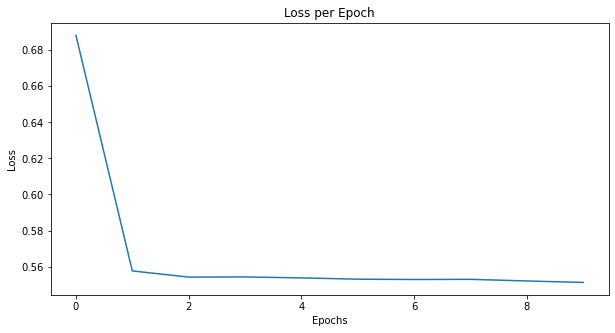

In [17]:
sgdlog.plot()

## Multi-Layer Perceptron

- One hidden layer with 50 neurons
- 50 neurons are ReLU activiation functions
- One output layer with 4 neurons (one for each class
- Output layer has ReLU activiation functions

In [18]:
class Neuron:
    
    def __init__(self):
        """ Initializes the Neuron """
        pass
    
    def forward(self, xi):
        """ Defines the foward pass of the neuron """
        pass
    
    def backward(self, xi, gradient, rate):
        """ Defines the backward pass for the neuron """
        pass
    

class ReLU(Neuron):
    
    def __init__(self):
        """ Initializes the Neuron """
        pass
    
    def forward(self, xi):
        """ Defines the ReLU function """
        return np.maximum(0, xi)
    
    def backward(self, xi, gradient, rate):
        """ Defines the gradient for the ReLU function """
        relu_g = xi > 0
        backpass = gradient * relu_g
        return backpass
        

class Tanh(Neuron):
    
    """ This was a thought, but it was not actually used """
    
    def __init__(self):
        """ Initializes the Neuron """
        pass
    
    def forward(self, xi):
        """ Defines the Tanh function """
        return np.tanh(xi)
    
    def backward(self, xi, gradient, rate):
        """ Defines the gradient for the Tanh function """
        backpass = (1 - np.square(np.tanh(xi))) * gradient
        return backpass
    

class Softmax(Neuron):
     
    def __init__(self):
        """ Initializes the Neuron """
        pass

    def forward(self, xi):
        """ Defines the Softmax function """
        exps = np.exp(xi - np.max(xi))  # Adding np.max(xi) for numeric stability
        return exps / np.sum(exps, axis=1, keepdims=True)
    
    def backward(self, xi, gradient, rate):
        """ Defines the gradient for the Softmax function """
        sm = self.forward(xi) 
        backpass = (sm - gradient) / xi.shape[0]  # Assume the gradient is one-hot encoded y
        return backpass
    

class Layer(Neuron):
    
    def __init__(self, xdim: int, ydim: int):
        """ Initializes the class """
        # Bias is assumed to be a feature for simplification purposes
        self._he_init = np.sqrt((2 / (xdim + ydim)))  # Initialize the weights with He initialization scheme
        self.w_ = np.random.normal(scale = self._he_init, size = (xdim, ydim))
        
    def forward(self, xi) -> np.ndarray:
        """ Performs the linear matrix operation for the layer """
        return xi.dot(self.w_)
    
    def backward(self, xi, gradient, rate):
        """ Performs the backward pass for the layer """
        # Mini-batch stochastic descent
        cost = xi.T.dot(gradient) / xi.shape[0]  # Assumes mini-batch stochastic gradient-descent 
        self.w_ -= rate * cost
        
        # Gradient for Input
        xi_gradient = gradient.dot(self.w_.T)
        return xi_gradient
    

class Network:
    
    def __init__(self, learning_rate: float = 0.1, max_epochs: int = 1000, precision: float = 1E-6, 
                 batch_size: int = None):
        """ Initializes the Network """
        self.network = []
        self.rate = learning_rate
        self.epochs = max_epochs
        self.precision = precision
        self.b_ = batch_size
        self.loss_ = None
        self.get_loss = None
        self.get_gradient = None
    
    def add_layer(self, layer) -> None:
        """ Adds a layer to the network """
        self.network.append(layer)
    
    def loss(self, func, func_prime):
        """ Sets the loss to use for the network """
        self.get_loss = func
        self.get_gradient = func_prime
            
    def predict(self, X) -> np.ndarray:
        """ Defines the predict function """
        results = self._feed_forward(X)
        return results[-1]
    
    def score(self, X, y) -> float:
        """ Scores the predictive ability of the Network """
        results = self.predict(X)
        labels = np.argmax(results, axis=1)
        y = np.argmax(y, axis=1)
        return sum(labels == y) / len(labels)
    
    def fit(self, X: np.ndarray, y: np.ndarray, verbose: bool = True):
        """ Fits the network to the training vectors """
        self.loss_ = list()
        for i in range(self.epochs):
            n, d = X.shape
            rand_indices = np.random.permutation(n)
            xi = X[rand_indices, :]
            yi = y[rand_indices, :]
            
            loss = self._train(xi, yi)
            self.loss_.append(loss)
            
            if verbose:
                print(f"Loss at epoch {i} is {loss}")
            
            if i > 0 and abs(self.loss_[i-1] - loss) <= self.precision:
                print(f"Precision reached at epoch {i}")
                break
    
    def plot(self) -> None:
        """ Plots the loss """
        epochs = len(self.loss_)
        fig = plt.figure(figsize=(10, 5))
        plt.plot(range(epochs), self.loss_)
        plt.title('Loss per Epoch')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.show()
    
    def _train(self, xi: np.ndarray, yi: np.ndarray) -> float:
        """ Implements mini-batch stochastic gradient descent """
        n, _ = xi.shape
        iters = int(n / self.b_)
        epoch_loss = 0.
        start = 0
        for k in range(iters):
            end = start + self.b_
            x = xi[start:end, :]
            y = yi[start:end, :]
            outputs = self._feed_forward(x)
            result = outputs[-1]
            
            loss = self.get_loss(result, y)
            epoch_loss += loss
            
            g = self.get_gradient(result, y)
            self._backward_pass(outputs, g)
            start = end
        return -epoch_loss / iters
        
    def _feed_forward(self, xi) -> np.ndarray:
        """ Feeds the sample forward through the network """
        outputs = [None] * (len(self.network) + 1)
        outputs[0] = xi
        for i, layer in enumerate(self.network):
            xi = layer.forward(xi)
            outputs[i + 1] = xi
        return outputs
    
    def _backward_pass(self, outputs, gradient) -> None:
        """ Implements a backward pass through the network """
        for i in range(len(outputs) - 1)[::-1]:
            xi = outputs[i]
            layer = self.network[i]
            gradient = layer.backward(xi, gradient, self.rate)

In [19]:
def cross_entropy_loss(x, y) -> float:
    """ Returns the loss of cross entropy logistic regression """
    loss = np.sum(np.multiply(y, np.log(x))) / x.shape[0]
    return loss

def cross_entropy_loss_g(x, y) -> np.ndarray:
    """ Returns gradient of loss for network """
    return y  # Only return y because the output layer has the gradient

In [20]:
def build_network(xdim: int, ydim: int, epochs: int = 30, batch_size = 12, neurons: int = 50) -> tuple:
    """ Gets everything ready to start """
    net = Network(0.1, max_epochs = epochs, batch_size = batch_size)
    net.add_layer(Layer(xdim, neurons))
    net.add_layer(ReLU())
    net.add_layer(Layer(neurons, ydim))
    net.add_layer(Softmax())
    net.loss(cross_entropy_loss, cross_entropy_loss_g)
    return net

In [21]:
net = build_network(X_train.shape[1], y_train.shape[1], epochs = 10, neurons = 50)
net.fit(X_train, y_train)

Loss at epoch 0 is 1.3299128294246967
Loss at epoch 1 is 1.0423288234211043
Loss at epoch 2 is 0.7296236418564748
Loss at epoch 3 is 0.5870615427832448
Loss at epoch 4 is 0.5209065741952724
Loss at epoch 5 is 0.48358347857386325
Loss at epoch 6 is 0.4597110369531102
Loss at epoch 7 is 0.44346904512119456
Loss at epoch 8 is 0.43139203020845496
Loss at epoch 9 is 0.42196074001523165


In [22]:
net.score(X_train, y_train), net.score(X_test, y_test)

(0.8572166666666666, 0.8452631578947368)

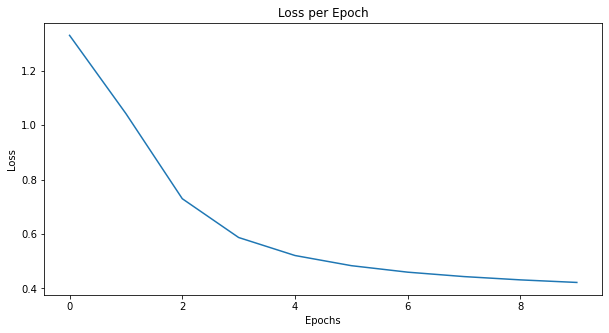

In [23]:
net.plot()

## K-Fold Cross Validation

In [24]:
def _get_folds(X, y, k, i) -> tuple:
    """ Gets the folds and returns them in a list """
    start = 0
    batch_size = int(X.shape[0] / k)
    X_folds, y_folds, X_val, y_val = (None, None, None, None)
    for j in range(k):
        end = start + batch_size
        X_batch = X[start:end, :].todense()
        y_batch = y[start:end, :]
        
        if j == i:
            X_val = X_batch
            y_val = y_batch
        else:
            if X_folds is None and y_folds is None:
                X_folds = X_batch
                y_folds = y_batch
            else:
                X_folds = np.vstack((X_folds, X_batch))
                y_folds = np.vstack((y_folds, y_batch))
        start = end
    return csr_matrix(X_folds), y_folds, csr_matrix(X_val), y_val

In [25]:
def report_results(options, name, results):
    columns = [name, "Group 0", "Group 1", "Group 2", "Group 3", "Average"]
    max_len = len(max(columns, key=lambda x: len(x)))
    header = " | ".join('{0:{width}}'.format(col, width=max_len) for col in columns)
    print(header)
    print("-" * len(header))
    for i, r in enumerate(results):
        r = np.round_(np.multiply(100, r), decimals=2)
        line = [options[i], r[0], r[1], r[2], r[3], np.average(r)]
        print(" | ".join('{0:{width}}'.format(str(r), width=max_len) for r in line))

### Neural Network Tuning: Hidden Layer

In [26]:
def nn_cross_validation(X, y, X_test, y_test, k: int, neurons: int) -> tuple:
    """ Implements k-fold cross validation for neural network """
    valloss, trainloss = (list(), list())
    valscore, testscore = (list(), list())
    testprec, testrecall, valprec, valrecall = (list(), list(), list(), list())
    
    network = build_network(X.shape[1], y.shape[1], epochs = 5, batch_size = 24, neurons = neurons)
    for i in range(k):
        X_folds, y_folds, X_val, y_val = _get_folds(X, y, k, i)
        network.fit(X_folds, y_folds, verbose = False)
        
        valscore.append(network.score(X_val, y_val))
        testscore.append(network.score(X_test, y_test))
        
        test_predictions = network.predict(X_test)
        val_predictions = network.predict(X_val)
        
        val_loss, train_loss = _get_nn_loss(network, val_predictions, y_val)
        valloss.append(val_loss)
        trainloss.append(train_loss)

        precision, recall = _get_nn_scores(test_predictions, y_test)
        testprec.append(precision) 
        testrecall.append(recall)
        
        precision, recall = _get_nn_scores(val_predictions, y_val)
        valprec.append(precision)
        valrecall.append(recall)
    
    valscore = np.mean(valscore)
    testscore = np.mean(testscore)
    
    testprec = np.mean(testprec, axis=0)  # Solve for each category, per k-fold
    testrecall = np.mean(testrecall, axis=0)
    
    valprec = np.mean(valprec, axis=0) 
    valrecall = np.mean(valrecall, axis=0)
    return valscore, testscore, valloss, trainloss, valprec, valrecall, testprec, testrecall


def _get_nn_loss(model, X_val, y_val) -> tuple:
    """ Gets the validation loss """
    val_loss = -1 * cross_entropy_loss(X_val, y_val)
    train_loss = sum(model.loss_) / len(model.loss_)
    return val_loss, train_loss


def _get_nn_scores(pred, y):
    """ Gets the recall and precision scores """
    labels = np.argmax(pred, axis=1)
    y = np.argmax(y, axis=1)
    return precision_score(y, labels, average=None), recall_score(y, labels, average=None)

In [27]:
k_folds = 3
nn_val_loss, nn_train_loss = (list(), list())
nn_val_score, nn_test_score = (list(), list())
nn_test_recall, nn_test_precision = (list(), list())
nn_val_recall, nn_val_precision = (list(), list())

num_neurons = [50, 75, 100, 150, 200]
for i, nn in enumerate(num_neurons):
    print(f"{i + 1}/{len(num_neurons)}: Validation for {nn} neurons...")
    results = nn_cross_validation(X_train, y_train, X_test, y_test, k_folds, nn)
    valscore, testscore, valloss, trainloss, valprec, valrecall, testprec, testrecall = results
    
    nn_val_score.append(valscore)
    nn_test_score.append(testscore)
    
    nn_train_loss.append(trainloss)
    nn_val_loss.append(valloss)
    
    nn_test_precision.append(testprec)
    nn_test_recall.append(testrecall)
    
    nn_val_precision.append(valprec)
    nn_val_recall.append(valrecall)
    print("Complete\n")

1/5: Validation for 50 neurons...
Complete

2/5: Validation for 75 neurons...
Complete

3/5: Validation for 100 neurons...
Complete

4/5: Validation for 150 neurons...
Complete

5/5: Validation for 200 neurons...
Complete



In [28]:
print("---------------------- TEST RECALL ----------------------\n")
report_results(num_neurons, "Neurons", nn_test_recall)

print("\n---------------------- TEST PRECISION ----------------------\n")
report_results(num_neurons, "Neurons", nn_test_precision)

print("\n---------------------- VALIDATION RECALL ----------------------\n")
report_results(num_neurons, "Neurons", nn_val_recall)

print("\n---------------------- VALIDATION PRECISION  ----------------------\n")
report_results(num_neurons, "Neurons", nn_val_precision)

---------------------- TEST RECALL ----------------------

Neurons | Group 0 | Group 1 | Group 2 | Group 3 | Average
---------------------------------------------------------
50      | 72.54   | 86.44   | 69.16   | 69.6    | 74.435 
75      | 75.23   | 86.46   | 72.21   | 70.81   | 76.1775
100     | 67.37   | 88.96   | 70.26   | 66.21   | 73.19999999999999
150     | 70.95   | 87.04   | 75.04   | 65.21   | 74.56  
200     | 73.81   | 85.65   | 72.65   | 62.93   | 73.76  

---------------------- TEST PRECISION ----------------------

Neurons | Group 0 | Group 1 | Group 2 | Group 3 | Average
---------------------------------------------------------
50      | 84.34   | 68.33   | 75.55   | 74.85   | 75.76750000000001
75      | 83.59   | 71.37   | 75.97   | 75.95   | 76.72  
100     | 85.13   | 66.32   | 73.59   | 77.43   | 75.6175
150     | 85.55   | 67.54   | 72.39   | 81.1    | 76.64500000000001
200     | 81.73   | 68.77   | 72.46   | 78.86   | 75.455 

---------------------- VALIDATION R

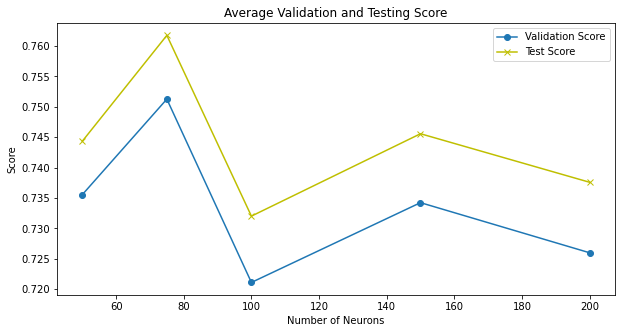

In [29]:
fig = plt.figure(figsize=(10, 5))
plt.plot(num_neurons, nn_val_score, marker='o')
plt.plot(num_neurons, nn_test_score, color='y', marker='x')
plt.title('Average Validation and Testing Score')
plt.xlabel('Number of Neurons')
plt.ylabel('Score')
plt.legend(['Validation Score', 'Test Score'])
plt.show()

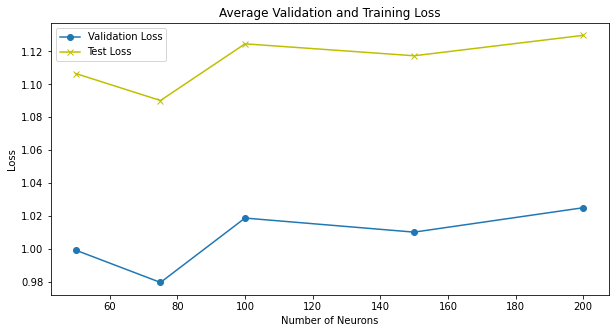

In [30]:
fig = plt.figure(figsize=(10, 5))
plt.plot(num_neurons, np.mean(nn_val_loss, axis=1), marker='o')
plt.plot(num_neurons, np.mean(nn_train_loss, axis=1), color='y', marker='x')
plt.title('Average Validation and Training Loss')
plt.xlabel('Number of Neurons')
plt.ylabel('Loss')
plt.legend(['Validation Loss', 'Test Loss'])
plt.show()

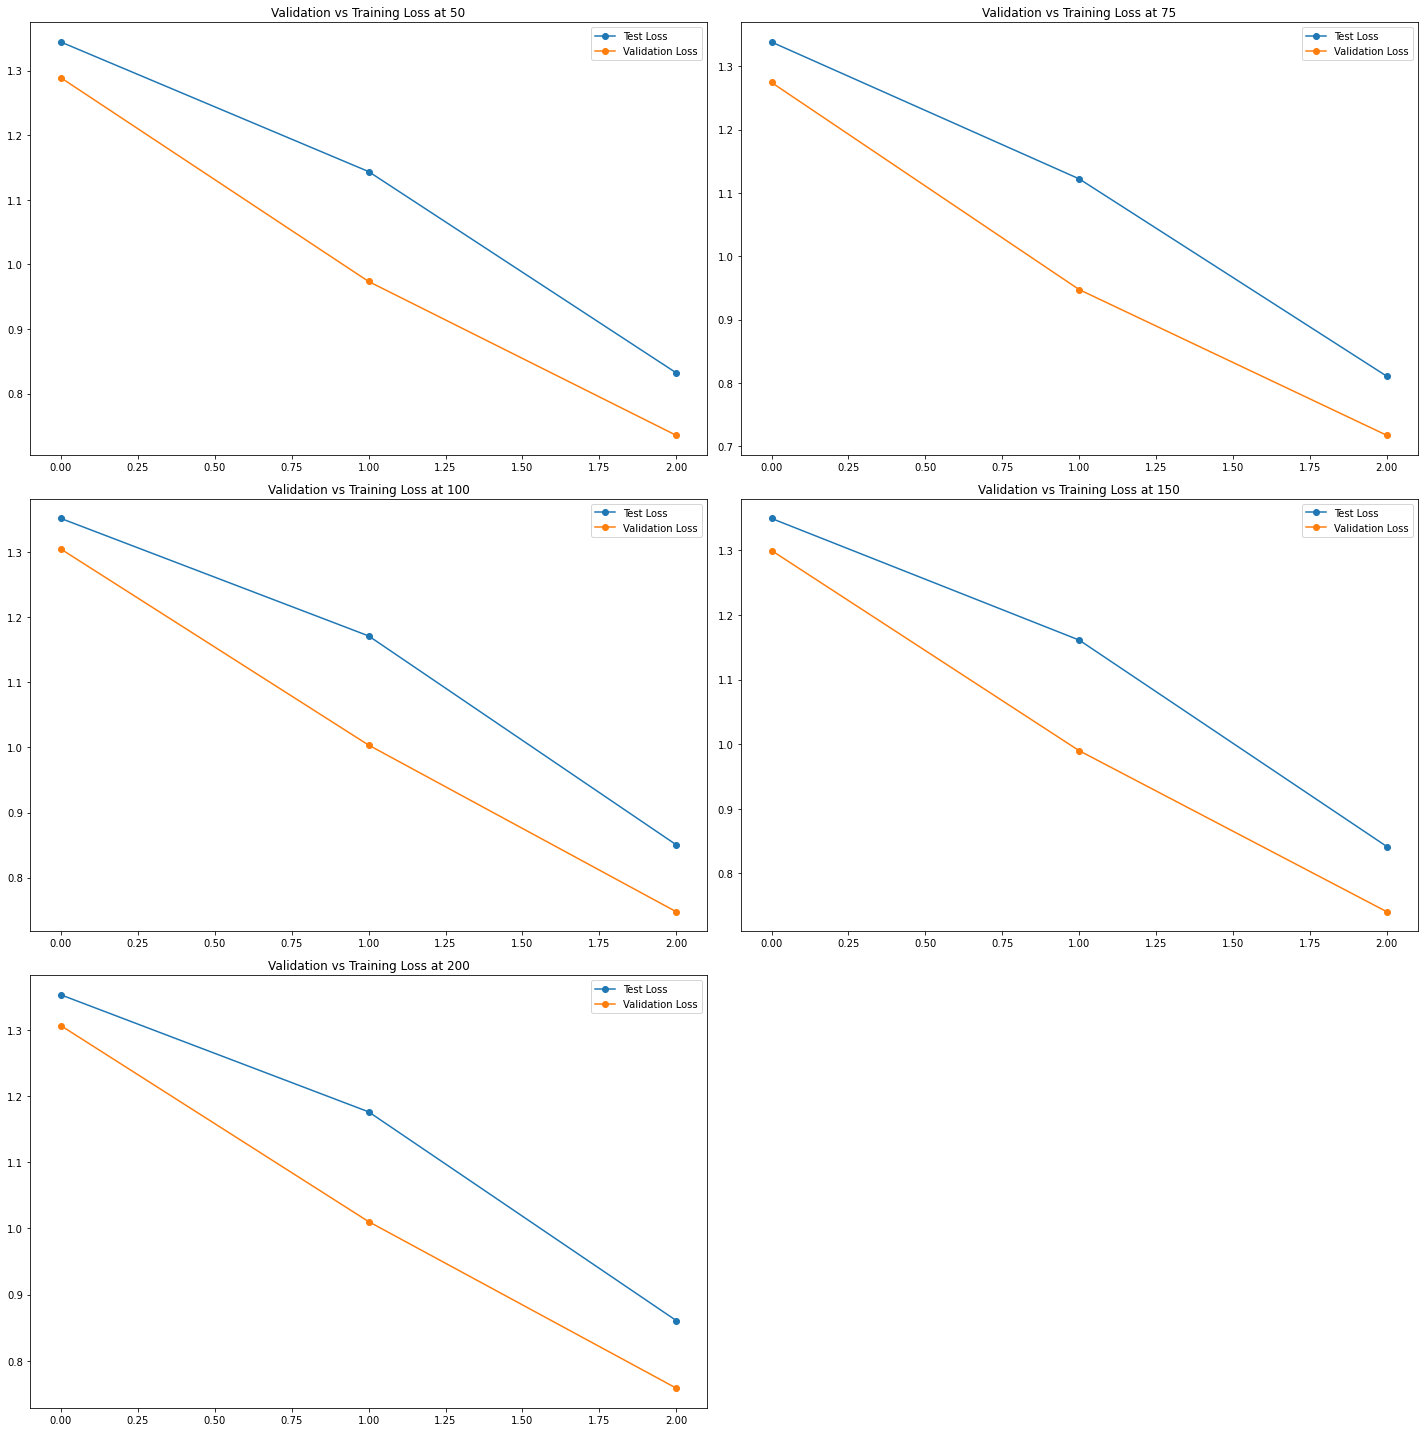

In [31]:
fig, axes = plt.subplots(3, 2, figsize=(20,20))
for idx, tloss in enumerate(nn_train_loss):
    x = idx // 2
    y = idx % 2
    vloss = nn_val_loss[idx]
    axes[x,y].plot(range(k_folds), tloss, marker='o')
    axes[x,y].plot(range(k_folds), vloss, marker='o')
    axes[x,y].set_title(f"Validation vs Training Loss at {num_neurons[idx]}")
    axes[x,y].legend(['Test Loss', 'Validation Loss'])
plt.tight_layout()
plt.axis('off')
plt.show()

Choose number of neurons to be 150 because it has, on average, the lowest loss and usually the highest or second highest precision. Moreover, the validation score is the highest.

### Logistic Regression: Lambda Tuning

In [32]:
def lr_cross_validation(X, y, X_test, y_test, k: int, lam: float) -> tuple:
    """ Implements k-fold cross-validation for logistic regression """
    valloss, trainloss = (list(), list())
    valscore, testscore = (list(), list())
    testprec, testrecall, valprec, valrecall = (list(), list(), list(), list())
    
    lr = LogisticRegression(0.1, optimizer='mbsgd', batch_size = 24, max_epochs = 5, lam = lam)
    for i in range(k):
        X_folds, y_folds, X_val, y_val = _get_folds(X, y, k, i)
        lr.fit(X_folds, y_folds, verbose = False)
        
        valscore.append(lr.score(X_val, y_val))
        testscore.append(lr.score(X_test, y_test))
        
        val_loss, train_loss = _get_lr_loss(lr, X_val, y_val)
        valloss.append(val_loss)
        trainloss.append(train_loss)

        test_predictions = lr.predict(X_test)
        val_predictions = lr.predict(X_val)
        
        precision, recall = _get_lr_scores(test_predictions, y_test)
        testprec.append(precision) 
        testrecall.append(recall)
        
        precision, recall = _get_lr_scores(val_predictions, y_val)
        valprec.append(precision)
        valrecall.append(recall)
        
    valscore = np.mean(valscore)
    testscore = np.mean(testscore)
    
    testprec = np.mean(testprec, axis=0)  # Solve for each category, per k-fold
    testrecall = np.mean(testrecall, axis=0)
    
    valprec = np.mean(valprec, axis=0) 
    valrecall = np.mean(valrecall, axis=0)
    return valscore, testscore, valloss, trainloss, valprec, valrecall, testprec, testrecall


def _get_lr_loss(model, X_val, y_val) -> tuple:
    """ Gets the validation loss """
    val_loss = model.loss(X_val, y_val)
    train_loss = sum(model.loss_) / len(model.loss_)
    return val_loss, train_loss


def _get_lr_scores(pred, y) -> tuple:
    """ Gets the recall and precision scores """
    y = np.argmax(y, axis=1)
    return precision_score(y, pred, average=None), recall_score(y, pred, average=None)

In [33]:
k_folds = 3
lr_val_loss, lr_train_loss = (list(), list())
lr_val_score, lr_test_score = (list(), list())
lr_test_recall, lr_test_precision = (list(), list())
lr_val_recall, lr_val_precision = (list(), list())

lambdas = [0.1, 0.01, 1E-3, 1E-4, 1E-5]
for i, lam in enumerate(lambdas):
    print(f"{i + 1}/{len(lambdas)}: Validation for Lambda {lam}...")
    results = lr_cross_validation(X_train, y_train, X_test, y_test, k_folds, lam)
    valscore, testscore, valloss, trainloss, valprec, valrecall, testprec, testrecall = results
    
    lr_val_score.append(valscore)
    lr_test_score.append(testscore)
    
    lr_train_loss.append(trainloss)
    lr_val_loss.append(valloss)
    
    lr_test_precision.append(testprec)
    lr_test_recall.append(testrecall)
    
    lr_val_precision.append(valprec)
    lr_val_recall.append(valrecall)
    print("Complete\n")

1/5: Validation for Lambda 0.1...
Complete

2/5: Validation for Lambda 0.01...
Complete

3/5: Validation for Lambda 0.001...
Complete

4/5: Validation for Lambda 0.0001...
Complete

5/5: Validation for Lambda 1e-05...
Complete



In [34]:
print("---------------------- TEST RECALL ----------------------\n")
report_results(lambdas, "Lambda", lr_test_recall)

print("\n---------------------- TEST PRECISION ----------------------\n")
report_results(lambdas, "Lambda", lr_test_precision)

print("\n---------------------- VALIDATION RECALL ----------------------\n")
report_results(lambdas, "Lambda", lr_val_recall)

print("\n---------------------- VALIDATION PRECISION  ----------------------\n")
report_results(lambdas, "Lambda", lr_val_precision)

---------------------- TEST RECALL ----------------------

Lambda  | Group 0 | Group 1 | Group 2 | Group 3 | Average
---------------------------------------------------------
0.1     | 84.3    | 80.39   | 53.79   | 62.21   | 70.1725
0.01    | 79.37   | 89.21   | 71.72   | 74.68   | 78.745 
0.001   | 80.37   | 88.18   | 73.93   | 74.23   | 79.17750000000001
0.0001  | 79.23   | 88.39   | 75.0    | 75.68   | 79.575 
1e-05   | 78.79   | 89.0    | 73.23   | 75.14   | 79.04  

---------------------- TEST PRECISION ----------------------

Lambda  | Group 0 | Group 1 | Group 2 | Group 3 | Average
---------------------------------------------------------
0.1     | 65.07   | 71.53   | 82.94   | 80.14   | 74.92  
0.01    | 83.48   | 73.82   | 80.03   | 79.43   | 79.19  
0.001   | 83.05   | 75.13   | 78.83   | 80.73   | 79.435 
0.0001  | 85.01   | 75.89   | 78.58   | 79.93   | 79.8525
1e-05   | 85.13   | 73.51   | 79.48   | 80.05   | 79.5425

---------------------- VALIDATION RECALL --------------

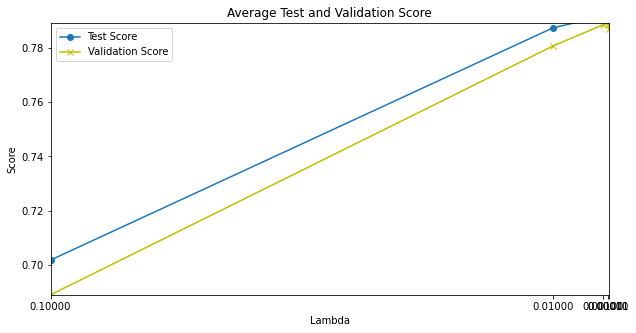

In [35]:
fig = plt.figure(figsize=(10, 5))
plt.plot(lambdas, lr_test_score , marker='o')
plt.plot(lambdas,  lr_val_score, color='y', marker='x')
plt.title('Average Test and Validation Score')
plt.xlabel('Lambda')
plt.ylabel('Score')
plt.legend(['Test Score', 'Validation Score'])
plt.xticks(lambdas)
plt.axis([max(lambdas), min(lambdas), min(lr_val_score), max(lr_val_score)])
plt.show()

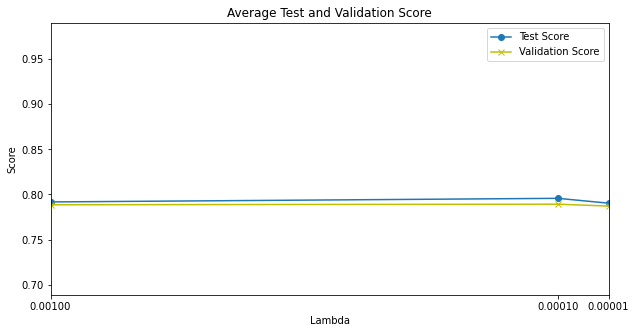

In [36]:
fig = plt.figure(figsize=(10, 5))
plt.plot(lambdas, lr_test_score , marker='o')
plt.plot(lambdas,  lr_val_score, color='y', marker='x')
plt.title('Average Test and Validation Score')
plt.xlabel('Lambda')
plt.ylabel('Score')
plt.legend(['Test Score', 'Validation Score'])
plt.xticks(lambdas)
plt.axis([0.001, min(lambdas), min(lr_val_score), 0.99])
plt.show()

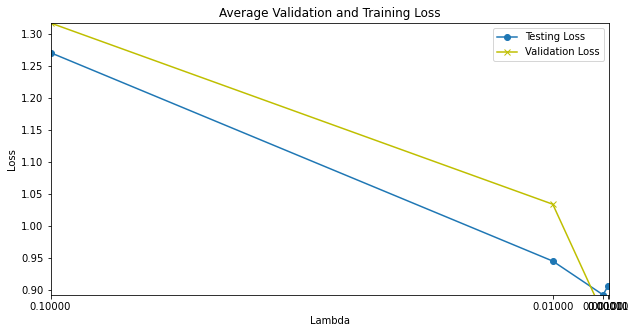

In [37]:
avg_vloss = np.mean(lr_val_loss, axis=1)
avg_tloss = np.mean(lr_train_loss, axis=1)
fig = plt.figure(figsize=(10, 5))
plt.plot(lambdas, avg_tloss, marker='o')
plt.plot(lambdas,  avg_vloss, color='y', marker='x')
plt.title('Average Validation and Training Loss')
plt.xlabel('Lambda')
plt.ylabel('Loss')
plt.legend(['Testing Loss', 'Validation Loss'])
plt.xticks(lambdas)
plt.axis([0.1, 1E-10, min(avg_tloss), max(avg_vloss)])
plt.show()

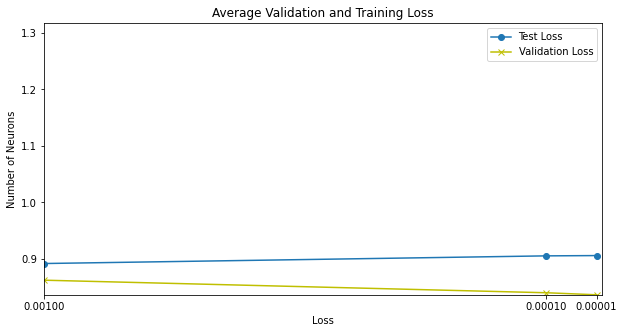

In [38]:
avg_vloss = np.mean(lr_val_loss, axis=1)
avg_tloss = np.mean(lr_train_loss, axis=1)
fig = plt.figure(figsize=(10, 5))
plt.plot(lambdas, avg_tloss, marker='o')
plt.plot(lambdas,  avg_vloss, color='y', marker='x')
plt.title('Average Validation and Training Loss')
plt.xlabel('Loss')
plt.ylabel('Number of Neurons')
plt.legend(['Test Loss', 'Validation Loss'])
plt.xticks(lambdas)
plt.axis([0.001, 1E-10, min(avg_vloss), max(avg_vloss)])
plt.show()

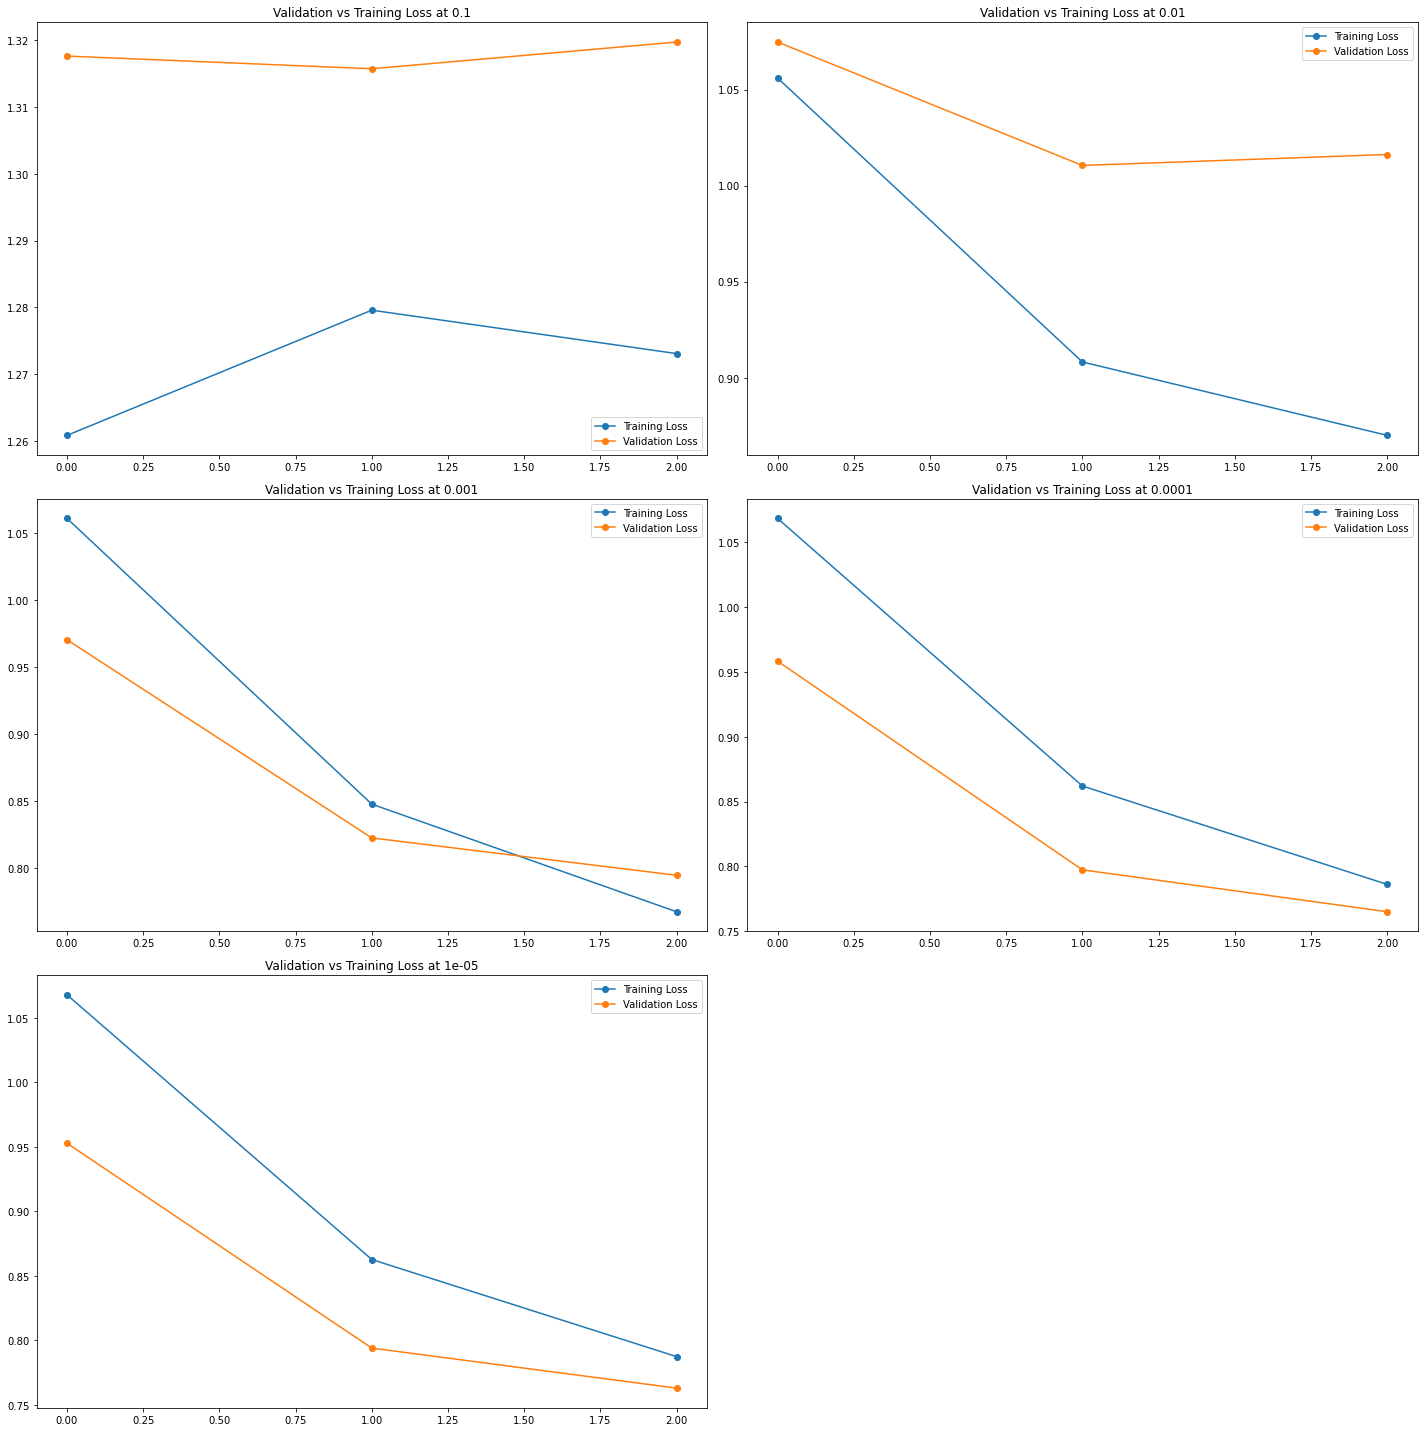

In [39]:
fig, axes = plt.subplots(3, 2, figsize=(20,20))
for idx, tloss in enumerate(lr_train_loss):
    x = idx // 2
    y = idx % 2
    vloss = lr_val_loss[idx]
    axes[x,y].plot(range(k_folds), tloss, marker='o')
    axes[x,y].plot(range(k_folds), vloss, marker='o')
    axes[x,y].set_title(f"Validation vs Training Loss at {lambdas[idx]}")
    axes[x,y].legend(['Training Loss', 'Validation Loss'])
plt.tight_layout()
plt.axis('off')
plt.show()

Choose $\lambda = 0.0001$ because it has the lowest loss and the highest precision and recall for both test and validation sets

## Testing Reults

### Neural Network with 150 Neurons

In [40]:
network = build_network(X_train.shape[1], y_train.shape[1], epochs = 20, batch_size = 12, neurons = 150)
network.fit(X_train, y_train)

Loss at epoch 0 is 1.3334136447596745
Loss at epoch 1 is 1.0498258094553687
Loss at epoch 2 is 0.7342562364316904
Loss at epoch 3 is 0.5898799043001595
Loss at epoch 4 is 0.5231351818166116
Loss at epoch 5 is 0.4855547772051652
Loss at epoch 6 is 0.46176687396332083
Loss at epoch 7 is 0.4453998223989315
Loss at epoch 8 is 0.43312307832391916
Loss at epoch 9 is 0.4242436629468811
Loss at epoch 10 is 0.41671490837185604
Loss at epoch 11 is 0.41094343772170816
Loss at epoch 12 is 0.40573261012670037
Loss at epoch 13 is 0.40150912371414277
Loss at epoch 14 is 0.3980182001602505
Loss at epoch 15 is 0.3947467683078272
Loss at epoch 16 is 0.39157181740973646
Loss at epoch 17 is 0.38936720065742814
Loss at epoch 18 is 0.38674419149058886
Loss at epoch 19 is 0.3846274260031087


In [41]:
network.score(X_train, y_train), network.score(X_test, y_test)

(0.864425, 0.8486842105263158)

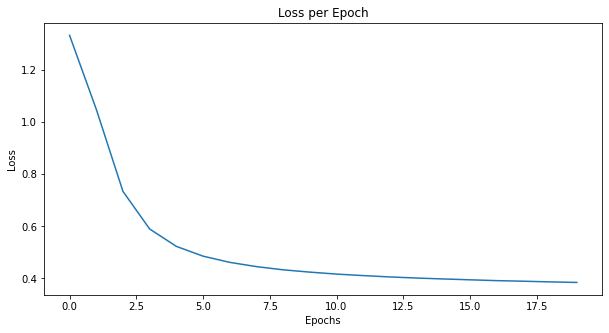

In [42]:
network.plot()

### Logistic Regression Testing with $\lambda = 0.0001$

In [43]:
mblog = LogisticRegression(0.1, optimizer='mbsgd', batch_size = 12, max_epochs = 20, lam = 0.0001)
mblog.fit(X_train, y_train)

Loss at epoch 0 is 1.1529540069362039
Loss at epoch 1 is 0.9025781195131196
Loss at epoch 2 is 0.7926468177075879
Loss at epoch 3 is 0.729405550244009
Loss at epoch 4 is 0.6875799443259498
Loss at epoch 5 is 0.6578635663401091
Loss at epoch 6 is 0.6354657913740313
Loss at epoch 7 is 0.6180447270845785
Loss at epoch 8 is 0.6041539761022906
Loss at epoch 9 is 0.5929074225609677
Loss at epoch 10 is 0.5835492835148343
Loss at epoch 11 is 0.5757186903265208
Loss at epoch 12 is 0.5690777562580736
Loss at epoch 13 is 0.5634532903938885
Loss at epoch 14 is 0.5585022799660274
Loss at epoch 15 is 0.5543928719099401
Loss at epoch 16 is 0.5507264815162511
Loss at epoch 17 is 0.5475478137998206
Loss at epoch 18 is 0.5448126441216345
Loss at epoch 19 is 0.5423424927846013


In [44]:
mblog.score(X_train, y_train), mblog.score(X_test, y_test)

(0.83425, 0.8321052631578948)

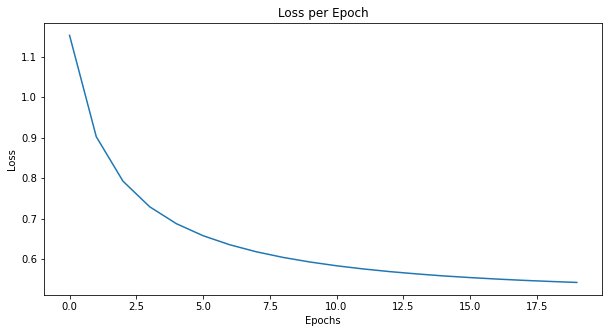

In [45]:
mblog.plot()

# Analysis

| Model | Train Accuracy | Test Accuracy | Solver | Batch Size | Epochs | Tuned |
|-------|:--------------:|:-------------:|--------|------------|--------|-------|
| Logitic Regression | 83.41% | 83.11% | Mini-batch Stochastic Gradient Descent | 12 | 20 | $\lambda$ of 0.0001|
| MLP                | 86.59% | 85.065% | Mini-batch Stochastic Gradient Descent | 12    | 20 | 150 Neurons |